# Using GPUs & TPUs with TF-Agents

### Profile in-notebook training

> Note: this notebook will only be useful if you have an accelerator (GPU or TPU) attached to the instance.

#### Goals

* Use the [TensorBoard Profiler](https://www.tensorflow.org/guide/profiler) to profile the RL training job, and compare this to other ML training jobs
* Visualize information such as operation statistics on different devices, tracing, etc. 
* Discuss these performance characteristics with respect to decisions in the code base (e.g., the structure of the Agent class), the use of TF helpers like `@tf.function`, and the order of operations in the input data pipeline

**Why?**
* Accelerators like GPUs and TPUs are certainly advantageous, but they are also the most expensive component(s) of a training job
* Before scaling to a full training job, it's best to make sure we are fully utilizing the chosen device(s), and doing this in-notebook can quickly help uncover any red flags 

We'll mainly look to address any bottlenecks in the input pipeline

## Load notebook config

* use the prefix defined in `00-env-setup`

In [1]:
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"
VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NAME      = "training_dataset"

REPOSITORY               = "rl-movielens-rec-bandits-v2"

DOCKERNAM

### imports

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
import functools
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint
import pickle as pkl

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform
from google.cloud import storage

# tensorflow
import tensorflow as tf

from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.metrics import tf_metrics

from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.bandits.networks import global_and_arm_feature_network

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.bandits.policies import policy_utilities
from tf_agents.trajectories import trajectory
from tf_agents.policies import policy_saver
from tf_agents.specs import array_spec

from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils as tfa_train_utils
from tf_agents.utils import common

# GPU
from numba import cuda 
import gc

import sys
sys.path.append("..")

# this repo
from src.utils import train_utils, reward_factory
from src.data import data_utils, data_config
from src.trainer import train_perarm as train_perarm
from src.networks import encoding_network as emb_features
from src.agents import agent_factory as agent_factory

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [6]:
import wrapt
from tensorflow.python.platform import build_info

print(f"cudnn version  : {build_info.build_info['cudnn_version']}")
print(f"cuda version   : {build_info.build_info['cuda_version']}")

print(f"wrapt          : {wrapt.__version__}")
print(f"tensorflow     : {tf.__version__}")
print(f"aiplatform SDK : {aiplatform.__version__}")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

cudnn version  : 8
cuda version   : 11.8
wrapt          : 1.16.0
tensorflow     : 2.13.0
aiplatform SDK : 1.71.0


In [9]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

In [10]:
print(f"device: {device.name.decode()}")

# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

device: Tesla T4


## Specify dataset

In [11]:
EXAMPLE_GEN_GCS_PATH = data_config.EXAMPLE_GEN_GCS_PATH
GCS_DATA_PATH = f"{BUCKET_URI}/{EXAMPLE_GEN_GCS_PATH}"

print(f"GCS_DATA_PATH: {GCS_DATA_PATH}")

!gsutil ls $GCS_DATA_PATH

GCS_DATA_PATH: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/action-embeddings/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v4/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v5/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v6/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/mv_b128_g12_a16_v7/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/val/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/


### Generate Vocabs

In [12]:
EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{EXAMPLE_GEN_GCS_PATH}/vocabs/{VOCAB_FILENAME}'
print(f"Downloading vocab...")

os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

filehandler = open(VOCAB_FILENAME, 'rb')
vocab_dict = pkl.load(filehandler)
filehandler.close()

# for key in vocab_dict.keys():
#     pprint(key)

Downloaded vocab from: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/vocab_dict.pkl



### train config

In [13]:
NUM_OOV_BUCKETS       = 1
GLOBAL_EMBEDDING_SIZE = 12
MV_EMBEDDING_SIZE     = 16 #32

NUM_GLOBAL_FEATURES   = len(data_utils.USER_FEATURE_NAMES)     # 6
NUM_ARM_FEATURES      = len(data_utils.MOVIE_FEATURE_NAMES)    # 5

EXPECTED_GLOBAL_DIM   = GLOBAL_EMBEDDING_SIZE * NUM_GLOBAL_FEATURES
EXPECTED_PER_ARM_DIM  = MV_EMBEDDING_SIZE * NUM_ARM_FEATURES

EXPECTED_GLOBAL_LAYERS   = [
    EXPECTED_GLOBAL_DIM,
    int(EXPECTED_GLOBAL_DIM/2),
    int(EXPECTED_GLOBAL_DIM/4)
]
EXPECTED_ARM_LAYERS      = [
    EXPECTED_PER_ARM_DIM,
    int(EXPECTED_PER_ARM_DIM/2),
    int(EXPECTED_PER_ARM_DIM/4)
]
EXPECTED_FIRST_COMMON_LAYER = EXPECTED_GLOBAL_LAYERS[-1] + EXPECTED_ARM_LAYERS[-1]
EXPECTED_COMMON_LAYERS = [
    int(EXPECTED_FIRST_COMMON_LAYER),
    # int(EXPECTED_FIRST_COMMON_LAYER/2),
    int(EXPECTED_FIRST_COMMON_LAYER/4)
]

print(f"NUM_OOV_BUCKETS        : {NUM_OOV_BUCKETS}")
print(f"GLOBAL_EMBEDDING_SIZE  : {GLOBAL_EMBEDDING_SIZE}")
print(f"MV_EMBEDDING_SIZE      : {MV_EMBEDDING_SIZE}")
print(f"EXPECTED_GLOBAL_DIM    : {EXPECTED_GLOBAL_DIM}")
print(f"EXPECTED_PER_ARM_DIM   : {EXPECTED_PER_ARM_DIM}")
print(f"EXPECTED_GLOBAL_LAYERS : {EXPECTED_GLOBAL_LAYERS}")
print(f"EXPECTED_ARM_LAYERS    : {EXPECTED_ARM_LAYERS}")
print(f"EXPECTED_COMMON_LAYERS : {EXPECTED_COMMON_LAYERS}")

NUM_OOV_BUCKETS        : 1
GLOBAL_EMBEDDING_SIZE  : 12
MV_EMBEDDING_SIZE      : 16
EXPECTED_GLOBAL_DIM    : 72
EXPECTED_PER_ARM_DIM   : 64
EXPECTED_GLOBAL_LAYERS : [72, 36, 18]
EXPECTED_ARM_LAYERS    : [64, 32, 16]
EXPECTED_COMMON_LAYERS : [34, 8]


In [14]:
BATCH_SIZE             = 128
EVAL_BATCH_SIZE        = 1
NUM_ACTIONS            = 2 
#this is kinda deceptive - 
#our approach is to learn by "flashing" one movie rating at a time per user context. 
#The n_actions = show/don't show the movie with one degree of freedom (n-1)

print(f"BATCH_SIZE      : {BATCH_SIZE}")
print(f"EVAL_BATCH_SIZE : {EVAL_BATCH_SIZE}")
print(f"NUM_ACTIONS     : {NUM_ACTIONS}")

BATCH_SIZE      : 128
EVAL_BATCH_SIZE : 1
NUM_ACTIONS     : 2


#### confirm GLOBAL and PER_ARM DIMs

**we only need a subset of data for profiling!**

In [15]:
SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{EXAMPLE_GEN_GCS_PATH}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files = train_files[:3]
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils._parse_function)

In [16]:
for i in range(1):
    
    iterator = iter(train_dataset.batch(1))
    data = next(iterator)

data

{'target_movie_genres': <tf.Tensor: shape=(1, 10), dtype=string, numpy=
 array([[b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
         b'UNK', b'UNK']], dtype=object)>,
 'target_movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'1775'], dtype=object)>,
 'target_movie_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>,
 'target_movie_title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Live Flesh (1997)'], dtype=object)>,
 'target_movie_year': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1997])>,
 'target_rating_timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([974612615])>,
 'user_age': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([50])>,
 'user_gender': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'M'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'2173'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'pr

In [17]:
embs = emb_features.EmbeddingModel(
    vocab_dict = vocab_dict,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
    max_genre_length = data_config.MAX_GENRE_LENGTH
)

embs

In [18]:
test_globals = embs._get_global_context_features(data)

GLOBAL_DIM = test_globals.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"GLOBAL_DIM: {GLOBAL_DIM}")

test_globals

GLOBAL_DIM: 72


<tf.Tensor: shape=(1, 72), dtype=float32, numpy=
array([[-5.3437129e-03,  9.9774115e-03, -4.3755677e-02, -6.0904771e-05,
        -1.7051257e-02, -3.0981779e-02, -3.7077188e-02,  7.2151423e-04,
        -2.0388592e-02, -2.3512781e-02, -4.2822827e-02,  1.4982406e-02,
         1.1481069e-02, -3.9166100e-03,  2.8252665e-02, -1.1605620e-03,
         4.9181644e-02,  2.3514379e-02,  3.9200101e-02, -4.6081115e-02,
         3.8794290e-02, -1.7589688e-02, -1.1914682e-02, -4.5916215e-03,
        -4.6122219e-02,  3.8709115e-02,  8.3737858e-03,  3.1476226e-02,
        -2.8594410e-02, -3.2128990e-02,  3.1156007e-02, -4.9312126e-02,
        -2.5086200e-02, -2.6846314e-02, -3.7086345e-02,  1.5891902e-03,
        -7.4606538e-03,  4.6644751e-02,  1.1959601e-02, -2.4643278e-02,
         1.6123954e-02,  4.1682255e-02,  2.5849070e-02,  3.7190866e-02,
        -1.1448167e-02, -2.4216676e-02, -3.7777651e-02, -4.8030186e-02,
         9.5635429e-03,  3.5476577e-02,  1.8451203e-02,  1.9779135e-02,
        -2.6063

In [19]:
test_arms = embs._get_per_arm_features(data)

PER_ARM_DIM = test_arms.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"PER_ARM_DIM: {PER_ARM_DIM}")

test_arms

PER_ARM_DIM: 64


<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[ 0.03854961,  0.0496678 , -0.03202371, -0.03784473, -0.03133249,
         0.00931675,  0.0489205 , -0.03041048, -0.02461534, -0.04410119,
         0.01829752, -0.02867211, -0.01244307,  0.02068056,  0.01124061,
        -0.02388291, -0.0191891 ,  0.02230248,  0.0253226 , -0.04809259,
        -0.01026721, -0.00539209, -0.01711877, -0.04864541, -0.00250176,
        -0.00195242, -0.03643131, -0.01024029,  0.04144907, -0.03945193,
        -0.02629283,  0.03216887,  0.05460138, -0.22400184,  0.2223845 ,
         0.16210532, -0.16665973, -0.12350518, -0.14543426,  0.11597478,
         0.1357097 , -0.04864138,  0.20791994,  0.16263498,  0.13680452,
        -0.01450295,  0.10119224,  0.15557422, -0.03766888, -0.03788178,
         0.01911067,  0.02078721, -0.00575375, -0.02572542,  0.01861191,
        -0.0182225 ,  0.02624685, -0.00716302, -0.01505066,  0.02732766,
        -0.01295121, -0.00144552,  0.00079996, -0.02101577]],
      dtype=f

### TensorSpecs

#### Observation Spec

In [20]:
observation_spec = {
    'global': tf.TensorSpec([GLOBAL_DIM], tf.float32),
    'per_arm': tf.TensorSpec([NUM_ACTIONS, PER_ARM_DIM], tf.float32) #excluding action dim here
}
observation_spec

{'global': TensorSpec(shape=(72,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

#### Action Spec

In [21]:
action_spec = tensor_spec.BoundedTensorSpec(
    shape=[], 
    dtype=tf.int32,
    minimum=tf.constant(0),            
    maximum=NUM_ACTIONS-1, # n degrees of freedom and will dictate the expected mean reward spec shape
    # name="action_spec"
)

action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(1, dtype=int32))

#### TimeStep Spec

In [22]:
time_step_spec = ts.time_step_spec(
    observation_spec = observation_spec, 
    # reward_spec = _reward_spec
)
time_step_spec

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(72,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

#### Reward Spec

In [23]:
from tf_agents.specs import array_spec

reward_spec = {
    "reward": array_spec.ArraySpec(shape=[BATCH_SIZE], dtype=np.float32, name="reward")
}

In [24]:
reward_tensor_spec = train_utils.from_spec(reward_spec)
reward_tensor_spec

{'reward': TensorSpec(shape=(128,), dtype=tf.float32, name='reward')}

## Distribution strategy

Use `strategy_utils` to generate a strategy. Under the hood, passing the parameter:

* `use_gpu = False` returns `tf.distribute.get_strategy()`, which uses CPU
* `use_gpu = True` returns `tf.distribute.MirroredStrategy()`, which uses all GPUs that are visible to TensorFlow on one machine

In [25]:
use_gpu = True
use_tpu = False

distribution_strategy = strategy_utils.get_strategy(tpu=use_tpu, use_gpu=use_gpu)
distribution_strategy

In [26]:
NUM_REPLICAS = distribution_strategy.num_replicas_in_sync
NUM_REPLICAS

1

### Config

In [27]:
# ================================
# Agents
# ================================
AGENT_TYPE      = 'epsGreedy' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'

# Parameters for linear agents (LinUCB and LinTS).
AGENT_ALPHA     = 0.1

# Parameters for neural agents (NeuralEpsGreedy and NerualLinUCB).
EPSILON         = 0.01
LR              = 0.05

# Parameters for NeuralLinUCB
ENCODING_DIM    = 1
EPS_PHASE_STEPS = 1000

# ==================================
# Agent's Preprocess Network layers
# ==================================
NETWORK_TYPE       = "commontower" # 'dotproduct' | 'dotproduct'

GLOBAL_LAYERS      = [GLOBAL_DIM, int(GLOBAL_DIM/2), int(GLOBAL_DIM/4)]
ARM_LAYERS         = [PER_ARM_DIM, int(PER_ARM_DIM/2), int(PER_ARM_DIM/4)]
FIRST_COMMON_LAYER = GLOBAL_LAYERS[-1] + ARM_LAYERS[-1] # min(GLOBAL_LAYERS[-1], ARM_LAYERS[-1])

COMMON_LAYERS = [
    int(FIRST_COMMON_LAYER), 
    # int(FIRST_COMMON_LAYER/2),
    int(FIRST_COMMON_LAYER/4)
]

if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    ENCODING_DIM = COMMON_LAYERS[-1]
    
if NETWORK_TYPE == 'dotproduct':
    assert GLOBAL_LAYERS[0] == ARM_LAYERS[0]

HPARAMS = {
    "batch_size": BATCH_SIZE,
    "eval_batch_size" : EVAL_BATCH_SIZE,
    "num_actions": NUM_ACTIONS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "learning_rate": LR,
    "epsilon": EPSILON,
}
pprint(HPARAMS)

{'batch_size': 128,
 'common_layers': [34, 8],
 'epsilon': 0.01,
 'eval_batch_size': 1,
 'global_layers': [72, 36, 18],
 'learning_rate': 0.05,
 'model_type': 'epsGreedy',
 'network_type': 'commontower',
 'num_actions': 2,
 'per_arm_layers': [64, 32, 16]}


### trajectory function

In [28]:
with distribution_strategy.scope():
    
    embs = emb_features.EmbeddingModel(
        vocab_dict = vocab_dict,
        num_oov_buckets = NUM_OOV_BUCKETS,
        global_emb_size = GLOBAL_EMBEDDING_SIZE,
        mv_emb_size = MV_EMBEDDING_SIZE,
        max_genre_length = data_config.MAX_GENRE_LENGTH
    )
    
    def _trajectory_fn(element): # hparams
    
        """Converts a dataset element into a trajectory."""
        global_features = embs._get_global_context_features(element)
        arm_features = embs._get_per_arm_features(element)

        # Adds a time dimension.
        arm_features = train_utils._add_outer_dimension(arm_features)

        # obs spec
        observation = {
            bandit_spec_utils.GLOBAL_FEATURE_KEY:
                train_utils._add_outer_dimension(global_features),
        }

        reward = train_utils._add_outer_dimension(reward_factory._get_rewards(element))

        # To emit the predicted rewards in policy_info, we need to create dummy
        # rewards to match the definition in TensorSpec for the ones specified in
        # emit_policy_info set.
        dummy_rewards = tf.zeros([HPARAMS['batch_size'], 1, HPARAMS['num_actions']])
        policy_info = policy_utilities.PerArmPolicyInfo(
            chosen_arm_features=arm_features,
            # Pass dummy mean rewards here to match the model_spec for emitting
            # mean rewards in policy info
            predicted_rewards_mean=dummy_rewards,
            bandit_policy_type=tf.zeros([HPARAMS['batch_size'], 1, 1], dtype=tf.int32)
        )

        if HPARAMS['model_type'] == 'neural_ucb':
            policy_info = policy_info._replace(
                predicted_rewards_optimistic=dummy_rewards
            )

        return trajectory.single_step(
            observation=observation,
            action=tf.zeros_like(
                reward, 
                dtype=tf.int32
            ),  # Arm features are copied from policy info, put dummy zeros here
            policy_info=policy_info,
            reward=reward,
            discount=tf.zeros_like(reward)
        )

In [29]:
# print(f"test_traj_v1.action.shape: {test_traj_v1.action.shape}")
# print(f"test_traj_v1.discount.shape: {test_traj_v1.discount.shape}") 
# print(f"test_traj_v1.observation.shape: {test_traj_v1.observation['global'].shape}") 
# print(f"test_traj_v1.reward.shape: {test_traj_v1.reward.shape}") 

## Create Agent

> Note: writting distributions and historgrams of gradients and variables will negatively impact training performance

* set `summarize_grads_and_vars = False` for best training performance
* keep `debug_summaries = True` to track training metrics (e.g., loss / regret)

In [30]:
with distribution_strategy.scope():
    
    global_step = tf.compat.v1.train.get_or_create_global_step()
    
    agent = agent_factory.PerArmAgentFactory._get_agent(
        agent_type = AGENT_TYPE,
        network_type = NETWORK_TYPE,
        time_step_spec = time_step_spec,
        action_spec = action_spec,
        observation_spec=observation_spec,
        global_layers = GLOBAL_LAYERS,
        arm_layers = ARM_LAYERS,
        common_layers = COMMON_LAYERS,
        agent_alpha = AGENT_ALPHA,
        learning_rate = LR,
        epsilon = EPSILON,
        train_step_counter = global_step,
        output_dim = ENCODING_DIM,
        eps_phase_steps = EPS_PHASE_STEPS,
        summarize_grads_and_vars = False,
        debug_summaries = True
    )
    
    agent.initialize()

print(f"Agent: {agent.name}")

if NETWORK_TYPE:
    print(f"NETWORK_TYPE: {NETWORK_TYPE}")

Agent: NeuralEpsGreedyAgent
NETWORK_TYPE: commontower


### GPU stuff

* `TF_GPU_THREAD_MODE=gpu_private` ensures that GPU kernels are launched from their own dedicated threads, and don't get queued behind tf.data work.

In [31]:
import os

TF_GPU_THREAD_COUNT   = '1'      # '1' | '4' | '8'

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_GPU_THREAD_MODE']='gpu_private'
os.environ['TF_GPU_THREAD_COUNT']=f"{TF_GPU_THREAD_COUNT}"
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'

## Vertex Experiment

In [32]:
VERSION="v2"

In [33]:
EXPERIMENT_NAME   = f'02c-bandit-gpu-{VERSION}' # customize as needed

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

CHECKPT_DIR       = f"{BUCKET_URI}/{EXPERIMENT_NAME}/chkpoint"
BASE_OUTPUT_DIR   = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}"
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"CHECKPT_DIR       : {CHECKPT_DIR}")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : 02c-bandit-gpu-v2
RUN_NAME          : run-20241126-151206

CHECKPT_DIR       : gs://rec-bandits-v2-hybrid-vertex-bucket/02c-bandit-gpu-v2/chkpoint
BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/02c-bandit-gpu-v2/run-20241126-151206
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/02c-bandit-gpu-v2/run-20241126-151206/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/02c-bandit-gpu-v2/run-20241126-151206/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/02c-bandit-gpu-v2/run-20241126-151206/artifacts


### TB Summary writer

In [34]:
# ====================================================
# TB summary writer
# ====================================================
with distribution_strategy.scope():
    train_summary_writer = tf.compat.v2.summary.create_file_writer(
        f"{LOG_DIR}", flush_millis=10 * 1000
    )

    train_summary_writer.set_as_default()

## Train loops

In [35]:
NUM_EPOCHS           = 1
NUM_ITER_STEPS       = 50
STEPS_PER_LOOP       = 1
LOG_INTERVAL         = 10
CHKPT_INTERVAL       = 1000

print(f"NUM_EPOCHS           : {NUM_EPOCHS}")
print(f"NUM_ITER_STEPS       : {NUM_ITER_STEPS}")
print(f"STEPS_PER_LOOP       : {STEPS_PER_LOOP}")
print(f"LOG_INTERVAL         : {LOG_INTERVAL}")
print(f"CHKPT_INTERVAL       : {CHKPT_INTERVAL}")

NUM_EPOCHS           : 1
NUM_ITER_STEPS       : 50
STEPS_PER_LOOP       : 1
LOG_INTERVAL         : 10
CHKPT_INTERVAL       : 1000


In [36]:
#start the timer and training
start_time = time.time()

# tf.profiler.experimental.start(LOG_DIR, options=profiler_options)
metric_results, agent = train_perarm.train_perarm(
    agent = agent,
    reward_spec = reward_tensor_spec,
    epsilon = HPARAMS['epsilon'],
    global_dim = GLOBAL_DIM,
    per_arm_dim = PER_ARM_DIM,
    num_epochs = NUM_EPOCHS,
    num_iterations = NUM_ITER_STEPS,
    steps_per_loop = STEPS_PER_LOOP,
    # data
    batch_size = HPARAMS['batch_size'],
    # functions
    _trajectory_fn = _trajectory_fn,
    # train intervals
    chkpt_interval = CHKPT_INTERVAL,
    log_interval = LOG_INTERVAL,
    # dirs
    bucket_name = BUCKET_NAME,
    data_dir_prefix_path = f"{EXAMPLE_GEN_GCS_PATH}",
    log_dir = LOG_DIR,
    model_dir = ARTIFACTS_DIR,
    chkpoint_dir = CHECKPT_DIR,
    use_gpu = True,
    use_tpu = False,
    profiler = True,
    global_step = global_step,
    train_summary_writer = train_summary_writer,
    # additional_metrics = metrics,
    cache_train_data = True,
    strategy = distribution_strategy,
    # saver=saver,
)
# tf.profiler.experimental.stop()
end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"complete train job in {runtime_mins} minutes")

distribution_strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f4d9b047ca0>
number of train_files: 8
Inpsecting agent policy from train_peram file...
agent.policy: <tf_agents.policies.epsilon_greedy_policy.EpsilonGreedyPolicy object at 0x7f4c505f6680>
Inpsecting agent policy from train_peram file: Complete
setting checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/02c-bandit-gpu-v2/chkpoint
agent.train_step_counter: 0
starting train loop...
epoch: 1
step = 10: loss = 12.789999961853027
step = 20: loss = 3.690000057220459
step = 30: loss = 1.1399999856948853
step = 40: loss = 1.4500000476837158
step = 50: loss = 1.1699999570846558
runtime_mins: 4
saved trained policy to: gs://rec-bandits-v2-hybrid-vertex-bucket/02c-bandit-gpu-v2/run-20241126-151206/artifacts
saved to checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/02c-bandit-gpu-v2/chkpoint
complete train job in 5 minutes


## Evaluate Train job

In [37]:
# len(metric_results)
metric_results[-1]

1.1748308

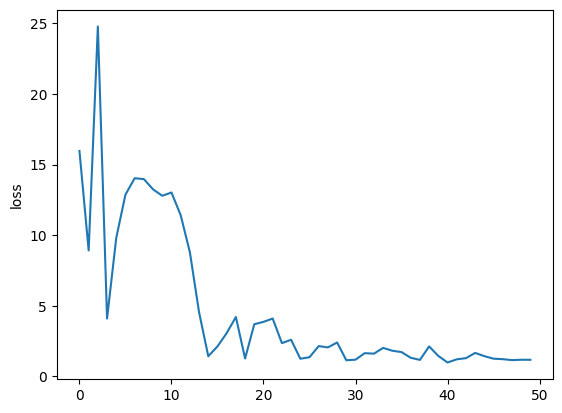

In [38]:
import matplotlib.pyplot as plt

plt.plot(metric_results)
plt.ylabel('loss')
plt.show()

### GPU profiling

#### Load TensorBoard

> on the right-hand side, find `PROFILE` in the drop down:

<img src="imgs/getting_profiler.png" 
     align="center" 
     width="850"
     height="850"/>
     
<!-- tf_vertex_agents/imgs/getting_profiler.png -->

In [44]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

In [40]:
# %load_ext tensorboard
%reload_ext tensorboard

In [43]:
# %tensorboard --logdir=$LOG_DIR

**Finished**